## Vanilla Recurrent Neural Network Implemented with `edf`

- I want to implement a vanilla recurrent net before an LSTM
- Back-Propagation Through Time (BPTT) is implemented with `edf`, the teaching framework from Toyota Technology Institute (Chiago). I decided not to implement the backward gradient by hand because it is prone to error. The tensor-flow auto-differentiation from `edf` was just the right amount of work, and debugging the tensor-flow was an effective learning experience. 
- The Recurrent network learns from [Shakespear's Coriolanus](./input.txt). 

In [1]:
import numpy as np
import edf
from time import time
import pickle
import os
from pprint import pprint
from tqdm import tqdm
from termcolor import cprint

%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
# hyperparameters
HIDDEN_SIZE = 200  # size of hidden layer of neurons
SEQ_LENGTH = 25  # number of steps to unroll the RNN for
ETA = 1e-3

In [3]:
# data I/O
data = open('input.txt', 'r').read()  # should be simple plain text file

#data = "this is a little fox. " * 1000
chars = list(set(data))
data_size, vocab_size = len(data), len(chars)
print('data has {} characters, {} unique.'.format(data_size, vocab_size))
char_to_ix = {ch: i for i, ch in enumerate(chars)}
ix_to_char = {i: ch for i, ch in enumerate(chars)}

data has 1115394 characters, 65 unique.


In [4]:
char_inds = np.array(list(map(lambda char: char_to_ix[char], data)))
tail = len(data) % SEQ_LENGTH
pad_length = SEQ_LENGTH - tail if tail else 0;

In [5]:
batched_data = np.append(char_inds, np.zeros(pad_length), axis=0)
batched_data.resize((int(len(data)/SEQ_LENGTH), SEQ_LENGTH))
# assert batched_data.shape == (44615, 25)

In [6]:
def one_hot(N, x):
    
    shape = x.shape
    x.resize(x.size)
    encoded = np.zeros([x.size, N])
    
    for i in range(x.size):
        encoded[i, int(x[i])] = 1
    
    encoded.resize(list(shape) + [N])
    x.resize(shape)
    # print(shape)
    return encoded

# tests:
encoded = one_hot(65, batched_data)
# assert encoded.shape == (44615, 25, 65), "shape is incorrect"
one_hot(5, np.array([3]))

array([[ 0.,  0.,  0.,  1.,  0.]])

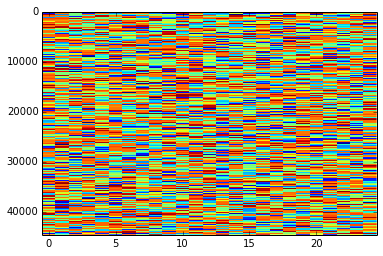

In [7]:
encoded = one_hot(65, batched_data)
plt.imshow(np.argmax(encoded, axis=2), aspect='auto', interpolation="none")
plt.show()

In [8]:
# clear edf params graph
edf.params = []

# Network definition
x = edf.Value()
y = edf.Value()
h = edf.Value()

Wxh = edf.Param(edf.xavier((vocab_size, HIDDEN_SIZE)))
Why = edf.Param(edf.xavier((HIDDEN_SIZE, vocab_size)))
Whh = edf.Param(edf.xavier((HIDDEN_SIZE, HIDDEN_SIZE)))

bh = edf.Param(np.zeros(HIDDEN_SIZE))
by = edf.Param(np.zeros(vocab_size))

minimum forward and backward computation example with the operators.

In [9]:
# single input, no batching.

def build_network(inputs, targets, h0):
    # clear edf.component graph
    edf.components = []
    
    # h and y are just plain python arrays
    input_len = inputs.shape[0]

    h = [h0] + [None]*input_len
    y = [None]*input_len
    
    loss = edf.Value(0)
    
    # unfold the forward passage
    for t in range(input_len):
        
        current_char = edf.Value(inputs[t])
        
        # print(ix_to_char[np.argmax(inputs[t])])
        
        h[t + 1] = edf.Tanh(
            edf.Add(
                edf.Add(
                    edf.VDot(
                        h[t]
                        , Whh
                    )
                    , edf.VDot(
                        edf.Value(inputs[t])
                        , Wxh
                    )
                )
                , bh
            )
        )

        y[t] = edf.Tanh(
            edf.Add(
                edf.VDot(
                    h[t + 1]
                    , Why
                )
                , by
            )
        )
        # find prediction before calculating score.
        # a better way is to compute score with the confidence level
        # in mind.
        
        pred = edf.SoftMax(y[t])
        log = edf.Log(edf.Sum(edf.Mul(pred, current_char))) # always over axis=-1
        
        loss = edf.Add(loss, edf.Mul(log, edf.Value(-1)))
        
    return y, loss, h

In [10]:
h0 = edf.Value(np.random.randn(HIDDEN_SIZE))

losses = []

for batch in batched_data:
    # print(batch)
    inputs = one_hot(vocab_size, batch)
    
    y, loss, h = build_network(inputs, inputs, h0)
    edf.Forward()
    
    h0 = edf.Value(h[-1].value)
    edf.Backward(loss)
    output = "".join(list(map(lambda pred: ix_to_char[np.argmax(pred.value)], y)
        ))    
    print(output, end='')
    losses.append(loss.value)
    edf.Adam(ETA)

 X          X XX                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                        

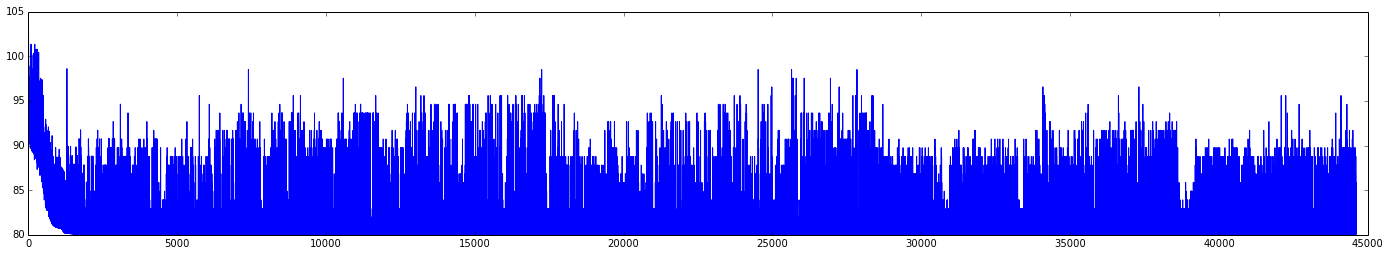

In [14]:
plt.figure(figsize=(24, 4))
plt.plot(losses)

In [13]:
# Attempt at diagnosing the component graph of `edf`.

for c in edf.components:
    if hasattr(c, 'y') and c.y and c.x:
        if c.x.value.shape == (100,) and c.grad.shape == (65,):
            print(c)
            print("x", c.x.value.shape)
            print("y", c.y.value.shape)
            print("del", c.grad.shape)